# Google Earth Engine Component

## Initialize

In [5]:
!pip install ee

In [6]:
!pip install geemap

In [7]:
!pip install varname

In [14]:
#Import required libraries
import ee
import geemap
import math

import numpy as np
import matplotlib.pyplot as plt

import itertools
from varname import nameof

import pandas as pd
from time import time

In [12]:
#Initialize Google Earth Engine
#ee.Authenticate() #just needed the 1st time
ee.Initialize()

EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, and then retry.

In [13]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

Enter verification code: 4/1AX4XfWhZcegoNZoupPHGT_RJKX9FQHu1atYQglhPVvyEnUQwQPwXA3w4pWA

Successfully saved authorization token.


## Load Feature Collection - Shapefiles

In [15]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [16]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7fd5f70791f0>,
 <ee.featurecollection.FeatureCollection at 0x7fd5f70a0550>)

In [17]:
#Income Data

la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

# Map.addLayer(la_county_income,{}, 'LA County Income')
# Map.addLayer(sf_county,{}, 'SF COUNTY')

## Load NAIP Imagery

In [18]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [19]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [20]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7fd5f6df9ca0>,
 '2010_sc_county': <ee.image.Image at 0x7fd5f6df9e80>,
 '2012_la_county': <ee.image.Image at 0x7fd5f6dfc0a0>,
 '2012_sc_county': <ee.image.Image at 0x7fd5f6dfc280>,
 '2014_la_county': <ee.image.Image at 0x7fd5f6dfc460>,
 '2014_sc_county': <ee.image.Image at 0x7fd5f6dfc640>,
 '2016_la_county': <ee.image.Image at 0x7fd5f6dfc820>,
 '2016_sc_county': <ee.image.Image at 0x7fd5f6dfca00>,
 '2018_la_county': <ee.image.Image at 0x7fd5f6dfcbe0>,
 '2018_sc_county': <ee.image.Image at 0x7fd5f6dfcdc0>,
 '2020_la_county': <ee.image.Image at 0x7fd5f6dfcfa0>,
 '2020_sc_county': <ee.image.Image at 0x7fd5f6e001c0>}

In [21]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [22]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [23]:
#test to see if NDVI plot looks correct 
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [24]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [25]:
PROJECT_DIR = 'projects/california-lawn-detection/assets/'

water = ee.FeatureCollection(f"{PROJECT_DIR}water_torrance_0610")
vegetation_trees = ee.FeatureCollection(f"{PROJECT_DIR}trees_torrance")
vegetation_grass = ee.FeatureCollection(f"{PROJECT_DIR}grass_torrance").limit(400)
turf_1 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance1")
turf_2 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance2")
pv = ee.FeatureCollection(f"{PROJECT_DIR}pv_torrance")
impervious_1 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance1").limit(40)
impervious_2 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance2").limit(40)
soil = ee.FeatureCollection(f"{PROJECT_DIR}soil_torrance").limit(40)

turf = turf_1.merge(turf_2)
impervious= impervious_1.merge(impervious_2)

LABELED_SET = water.merge(vegetation_trees)\
                   .merge(vegetation_grass)\
                   .merge(turf)\
                   .merge(impervious)\
                   .merge(soil)
    
Map.addLayer(LABELED_SET, {}, 'labeled_set')

In [27]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Build Training Set

In [28]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [29]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 'G', 'B', 'N', 'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy',
         'N_Contrast', 
         'N_Gearys']

training_set = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

In [30]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [31]:
def training_area(image, training_class):
    
    area = image.reduceRegion(
           reducer = ee.Reducer.count(), 
           geometry = training_class.geometry(), 
           scale = 2, 
           maxPixels = 1e13
                )

    return(area.getInfo().get('B'))

In [32]:
def training_polygons(training_class):
    return(training_class.aggregate_count('label').getInfo())

In [33]:
# training information
training_classes = [water,
                         vegetation_trees,
                         vegetation_grass,
                         turf,
                         pv,
                         impervious,
                         soil]

class_names = ['water',
                         'vegetation_trees',
                         'vegetation_grass',
                         'turf',
                         'pv',
                         'impervious',
                         'soil']

try:
    for i in range(len(training_classes)):
        area_i = training_area(TRAINING_IMAGE, training_classes[i])
        polygons_i = training_polygons(training_classes[i])
        print(class_names[i],"pixels:", area_i ,", polygons", polygons_i)
except:
    print('ERROR. POSSIBLE MISMATCH IN CLASSES LIST AND NAMES LIST SIZES')



water pixels: 486 , polygons 199
vegetation_trees pixels: 17125 , polygons 772
vegetation_grass pixels: 23681 , polygons 400
turf pixels: 857 , polygons 215
pv pixels: 1723 , polygons 344
impervious pixels: 20360 , polygons 80
soil pixels: 8761 , polygons 40


## Separate Training Data into Train/Test

In [34]:
#Split Training and Test Set Randomly - there might be a better way to do this
print("Labeled Set Size in Pixels", training_set.aggregate_count('R').getInfo())
sample = training_set.randomColumn()
trainingSample = sample.filter('random <= 0.8')
validationSample = sample.filter('random > 0.8')
print("Training Set Size in Pixels", trainingSample.aggregate_count('R').getInfo())
print("Test Set Size in Pixels", validationSample.aggregate_count('R').getInfo())

Labeled Set Size in Pixels 284710
Training Set Size in Pixels 227871
Test Set Size in Pixels 56839


## Machine Learning Model

In [63]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 100).train(trainingSample, LABEL, BANDS)
clf

In [64]:
training_image_classified = TRAINING_IMAGE.select(BANDS).classify(clf)

In [65]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [66]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Evaluation Metrics

### Train Accuracy

In [67]:
train_accuracy = trainingSample.classify(clf).errorMatrix('landcover', 'classification')
train_accuracy.getInfo()

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1473, 0, 0, 0, 0, 0, 0],
 [0, 0, 54688, 21, 0, 0, 0, 0],
 [0, 0, 147, 75601, 0, 0, 0, 2],
 [0, 0, 0, 0, 2637, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 65382, 0],
 [0, 0, 0, 0, 0, 0, 1, 27918]]

In [68]:
train_accuracy.accuracy().getInfo()

0.9992451869698207

In [69]:
np.array(train_accuracy.getInfo()).sum()

227871

### Test Accuracy

In [70]:
test_accuracy = validationSample.classify(clf).errorMatrix('landcover', 'classification')

In [71]:
test_accuracy.accuracy().getInfo()

0.9786238322278717

In [72]:
np.array(test_accuracy.getInfo()).sum()

56839

## Binary Classification and Area Calculation

In [73]:
def area_calculation(image, class_number, shape, pixel_scale = 20):
    
    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())
    
    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(), 
        geometry = shape.geometry(), 
        scale = pixel_scale, 
        maxPixels = 1e13)
    
    area_sq_m = area.getInfo().get('classification')
    
    area_sq_km = area_sq_m / 1e6
    
    return area_sq_km

In [74]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012, 2014, 2016, 2018,2020],
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7fdeaef86730>,
 '2012_lacounty': <ee.image.Image at 0x7fdeaef86910>,
 '2014_lacounty': <ee.image.Image at 0x7fdeaef86af0>,
 '2016_lacounty': <ee.image.Image at 0x7fdeaef86cd0>,
 '2018_lacounty': <ee.image.Image at 0x7fdeaef86eb0>,
 '2020_lacounty': <ee.image.Image at 0x7fdeaef8a0d0>}

In [75]:
grass_areas = {}

for i in inference_images:
    im = inference_images[i]
    im_classified = im.select(BANDS).classify(clf)
    grass_areas[i] = area_calculation(im_classified, 3, la_county, 20)
    print(i, 'completed')

2010_lacounty completed
2012_lacounty completed
2014_lacounty completed
2016_lacounty completed
2018_lacounty completed
2020_lacounty completed


In [76]:
grass_areas

{'2010_lacounty': 3069.2586644971657,
 '2012_lacounty': 1265.0236710808854,
 '2014_lacounty': 1227.6888985192109,
 '2016_lacounty': 704.2648467338138,
 '2018_lacounty': 1129.6989987678303,
 '2020_lacounty': 826.858711155899}

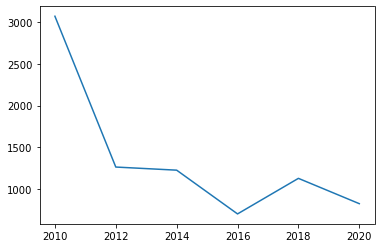

In [77]:
values = np.array(list(grass_areas.values()))
plt.plot(test_image_params['years'], values)

In [78]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))




In [79]:
Zipcode_list = ['90802','90732','90744']

In [80]:
list(inference_images.items())

[('2010_lacounty', <ee.image.Image at 0x7fdeaef86730>),
 ('2012_lacounty', <ee.image.Image at 0x7fdeaef86910>),
 ('2014_lacounty', <ee.image.Image at 0x7fdeaef86af0>),
 ('2016_lacounty', <ee.image.Image at 0x7fdeaef86cd0>),
 ('2018_lacounty', <ee.image.Image at 0x7fdeaef86eb0>),
 ('2020_lacounty', <ee.image.Image at 0x7fdeaef8a0d0>)]

In [81]:
inference_images['2020_lacounty']

In [82]:
training_image_classified

In [83]:
keys = {'ImageYear','polygon','water_area','vegetation_trees_area', 'vegetation_grass_area', 'turf_area', 'impervious_area','soil_area', 'total_area'}
dictionary = {}
for i in keys:
    dictionary[i] = []

im = inference_images['2020_lacounty']
imagery = im.select(BANDS).classify(clf)


for i in Zipcode_list:
    for j in list(inference_images.items()):
        im = j[1]
        imagery = im.select(BANDS).classify(clf)
        name = j[0]
        
        start = time()
        polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

        dictionary['ImageYear'].append(j[0]) 
        dictionary['polygon'].append(i)

        water_area = area_calculation(imagery, 1, polygon, 20)
        dictionary['water_area'].append(water_area)

        vegetation_trees_area = area_calculation(imagery, 2, polygon, 20)
        dictionary['vegetation_trees_area'].append(vegetation_trees_area)

        vegetation_grass_area = area_calculation(imagery, 3, polygon, 20)
        dictionary['vegetation_grass_area'].append(vegetation_grass_area)

        turf_area = area_calculation(imagery, 4, polygon, 20)
        dictionary['turf_area'].append(turf_area)

        impervious_area = area_calculation(imagery, 6, polygon, 20)
        dictionary['impervious_area'].append(impervious_area)

        soil_area = area_calculation(imagery, 7, polygon, 20)
        dictionary['soil_area'].append(soil_area)

        total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
        dictionary['total_area'].append(total_area)
        end = time()
        print(i, j[0] , f'completed in {end-start} seconds.')

90802 2010_lacounty completed in 9.413926362991333 seconds.
90802 2012_lacounty completed in 10.213822841644287 seconds.
90802 2014_lacounty completed in 10.014098167419434 seconds.
90802 2016_lacounty completed in 11.06235408782959 seconds.
90802 2018_lacounty completed in 9.439943552017212 seconds.
90802 2020_lacounty completed in 27.44849705696106 seconds.
90732 2010_lacounty completed in 9.24148941040039 seconds.
90732 2012_lacounty completed in 9.613401412963867 seconds.
90732 2014_lacounty completed in 9.479886531829834 seconds.
90732 2016_lacounty completed in 9.714132308959961 seconds.
90732 2018_lacounty completed in 9.290303707122803 seconds.
90732 2020_lacounty completed in 9.391974925994873 seconds.
90744 2010_lacounty completed in 9.039168119430542 seconds.
90744 2012_lacounty completed in 9.51382040977478 seconds.
90744 2014_lacounty completed in 9.661619186401367 seconds.
90744 2016_lacounty completed in 9.854579210281372 seconds.
90744 2018_lacounty completed in 9.28030

In [84]:
pd.DataFrame(dictionary)[['ImageYear','polygon','soil_area','vegetation_grass_area','water_area','vegetation_trees_area','impervious_area','turf_area']]

,ImageYear,polygon,soil_area,vegetation_grass_area,water_area,vegetation_trees_area,impervious_area,turf_area
0,2010_lacounty,90802,3.407064,5.416788,0.007960,0.670206,5.241610,0.012990
1,2012_lacounty,90802,0.000000,0.229415,4.845066,0.000995,9.679151,0.001990
2,2014_lacounty,90802,0.003980,0.476647,0.249989,0.076949,13.791756,0.157296
3,2016_lacounty,90802,0.257569,0.394952,0.000000,0.315657,13.563885,0.224554
4,2018_lacounty,90802,0.001327,0.305056,0.326028,0.101922,13.840988,0.181296
5,2020_lacounty,90802,0.760027,0.496773,0.000000,0.647374,12.688006,0.164438
6,2010_lacounty,90732,1.259774,2.307484,0.000000,0.375581,4.284398,0.004312
7,2012_lacounty,90732,0.061377,1.454733,1.001374,0.102173,5.577262,0.034631
8,2014_lacounty,90732,0.531687,2.614109,0.035535,0.423377,4.592798,0.034044
9,2016_lacounty,90732,0.679698,0.730300,0.007975,0.913194,5.818238,0.082145


In [85]:
df = pd.DataFrame(dictionary)[['polygon','soil_area','vegetation_grass_area','water_area','vegetation_trees_area','impervious_area','turf_area']]
df

,polygon,soil_area,vegetation_grass_area,water_area,vegetation_trees_area,impervious_area,turf_area
0,90802,3.407064,5.416788,0.007960,0.670206,5.241610,0.012990
1,90802,0.000000,0.229415,4.845066,0.000995,9.679151,0.001990
2,90802,0.003980,0.476647,0.249989,0.076949,13.791756,0.157296
3,90802,0.257569,0.394952,0.000000,0.315657,13.563885,0.224554
4,90802,0.001327,0.305056,0.326028,0.101922,13.840988,0.181296
5,90802,0.760027,0.496773,0.000000,0.647374,12.688006,0.164438
6,90732,1.259774,2.307484,0.000000,0.375581,4.284398,0.004312
7,90732,0.061377,1.454733,1.001374,0.102173,5.577262,0.034631
8,90732,0.531687,2.614109,0.035535,0.423377,4.592798,0.034044
9,90732,0.679698,0.730300,0.007975,0.913194,5.818238,0.082145


In [86]:
years= [2010, 2012, 2014, 2016, 2018, 2020]
zips = df['polygon'].unique()
zips

array(['90802', '90732', '90744'], dtype=object)

In [87]:
for i in df:
    print(i)

polygon
soil_area
vegetation_grass_area
water_area
vegetation_trees_area
impervious_area
turf_area


In [88]:
list(df.columns)

['polygon',
 'soil_area',
 'vegetation_grass_area',
 'water_area',
 'vegetation_trees_area',
 'impervious_area',
 'turf_area']

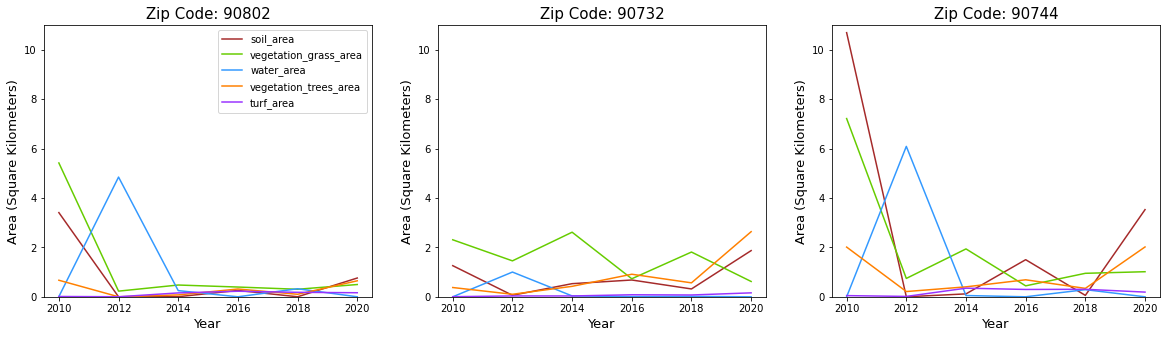

In [89]:
zips = df.polygon.unique()
fig, ax = plt.subplots(1,3, figsize = (20,5))


labels = [ 'soil_area',
 'vegetation_grass_area',
 'water_area',
 'vegetation_trees_area',
 'turf_area']

colors = ['brown','#66CC00','#3399FF','#FF8000','#9933FF']


for i in range(3):
    for j in range(len(labels)):
        if j == 'polygon':
            continue
        else:
            d = df[df.polygon == zips[i]]
            ax[i].plot(years, d[labels[j]], color = colors[j], label = labels[j])
    ax[i].set_title(f'Zip Code: {zips[i]}', size = 15)
    ax[i].set_xlabel('Year', size = 13)
    ax[i].set_ylabel('Area (Square Kilometers)', size = 13)
    ax[i].set_ylim(0,11)
    ax[0].legend()
    
plt.savefig(fname = 'test.png', dpi = 200)

In [90]:
for i in df:
    print(i)

polygon
soil_area
vegetation_grass_area
water_area
vegetation_trees_area
impervious_area
turf_area


In [91]:
# classified = training_image_classified

# water_area = area_calculation(classified, 1, la_county, 20)
# vegetation_trees_area = area_calculation(classified, 2, la_county, 20)
# vegetation_grass_area = area_calculation(classified, 3, la_county, 20)
# turf_area = area_calculation(classified, 4, la_county, 20)
# impervious_area = area_calculation(classified, 6, la_county, 20)
# soil_area = area_calculation(classified, 7, la_county, 20)

# total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area

# water_percentage = water_area / total_area
# vegetation_trees_percentage = vegetation_trees_area / total_area
# vegetation_grass_percentage = vegetation_grass_area / total_area
# turf_percentage = turf_area / total_area
# impervious_percentage = impervious_area / total_area
# soil_percentage = soil_area / total_area